In [ ]:
# Mounting your Google Drive is optional, and you could also simply copy and
# upload the data to your colab instance. This manula upload is also easy to do,
# but you will have to figure out how to do it.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
if not os.path.exists("/content/gdrive/MyDrive/CS543/MP4"):
    os.makedirs("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4")
os.chdir("/content/gdrive/MyDrive/CS543/MP4")

In [ ]:
# download dataset
if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4/data"):
  %pip install -U gdown
  import gdown
  url = "https://drive.google.com/uc?id=1sdmNN6b3stiDCwyZbVsl5vS5VbPnKixa"
  gdown.download(url, quiet=False)
  !unzip -qqo data.zip
  !rm data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


Downloading...
From: https://drive.google.com/uc?id=1sdmNN6b3stiDCwyZbVsl5vS5VbPnKixa
To: /content/gdrive/.shortcut-targets-by-id/1Semr4OmC4V4RNBav-0b0pMqLJsD3K0wb/CS543/MP4/data.zip
100%|██████████| 10.7M/10.7M [00:00<00:00, 25.1MB/s]


In [ ]:
!pwd

/content/gdrive/.shortcut-targets-by-id/1Semr4OmC4V4RNBav-0b0pMqLJsD3K0wb/CS543/MP4


In [ ]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize

In [ ]:
# global variable
device = torch.device("cuda:0")

In [ ]:
class SegmentationDataset(data.Dataset):
    """
    Data loader for the Segmentation Dataset. If data loading is a bottleneck,
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as
    to limit delays due to disk reads.
    """

    def __init__(self, split="train", data_dir="data"):
        assert (split in ["train", "val", "test"])
        self.img_dir = os.path.join(data_dir, split)
        self.classes = []
        with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
            for l in f:
                self.classes.append(l.rstrip())
        self.n_classes = len(self.classes)
        self.split = split
        self.data = glob.glob(self.img_dir + '/*.jpg')
        self.data = sorted([os.path.splitext(l)[0] for l in self.data])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = Image.open(self.data[index] + '.jpg')
        if self.split == 'test':
            gt = Image.new('RGB', img.size)
        else:
            gt = Image.open(self.data[index] + '.png')
        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        gt = np.asarray(gt)
        gt = torch.from_numpy(np.array(gt)).long().unsqueeze(0)
        return img, gt

In [ ]:
train_dataset = SegmentationDataset(split='train')

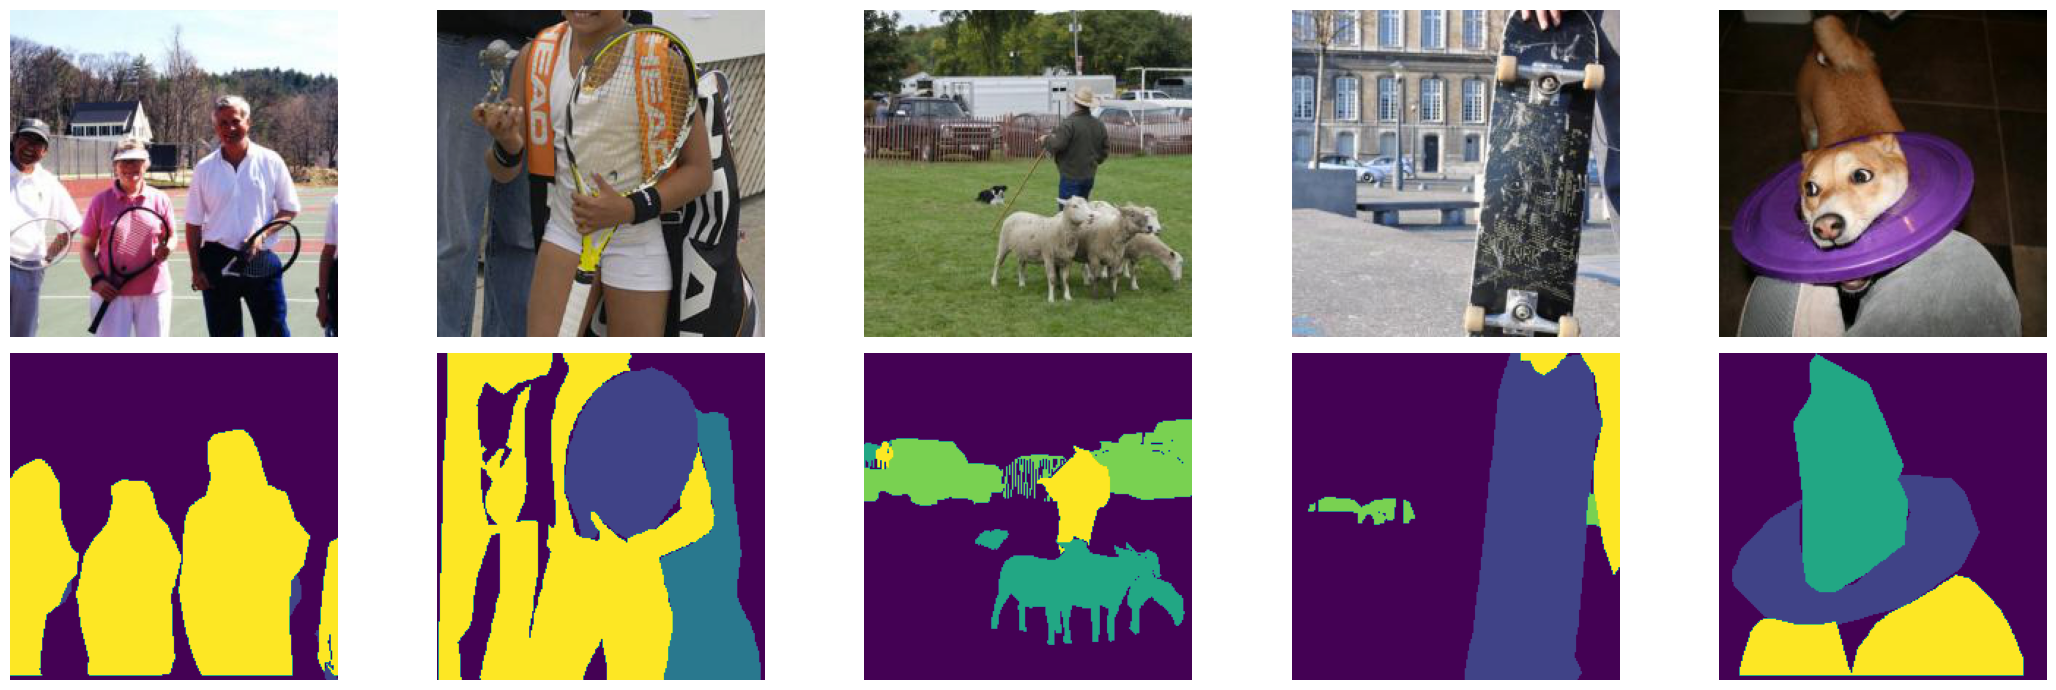

In [ ]:
# vis the training set
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    img, gt = train_dataset[idx]
    img = std * img.permute((1, 2, 0)).cpu().numpy() + mean
    gt = gt.squeeze().numpy()
    ax.imshow((img * 255).astype(np.uint8))
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(gt)
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_trainset.pdf', format='pdf', bbox_inches='tight')

In [ ]:

import torch.nn as nn

##########
#TODO: design your own network here. The expectation is to write from scratch. But it's okay to get some inspiration
#from conference paper. We are providing a very simple network that does a single 1x1 convolution to prdict the class label.
##########
class MyModel(nn.Module):

    def __init__(self, n_classes): # modify model
        super(MyModel, self).__init__()
        self.res18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(self.res18.children())[:-2])
        self.layers = nn.Sequential(nn.Conv2d(512, n_classes, 1, padding=0))
        # self.up=nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)



    def forward(self, img): # modify forward path
        #x = self.res18(img)
        x=self.encoder(img)
        #print(x.shape)
        x=self.layers(x)
        # x=self.up(x)
        x = torch.nn.functional.interpolate(x, (224, 224), mode='bilinear')
        return x



In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# class MyModel(nn.Module):
#   def __init__(self, n_classes): # modify model
#     super(MyModel, self).__init__()
#     self.res18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
#     self.encoder = nn.Sequential(*list(self.res18.children())[:-2])
#     # Add atrous convolutional layers for semantic segmentation
#     # Example: Binary classification task
#     self.resnet_decoder = nn.Sequential(
#         nn.Conv2d(512, n_classes, kernel_size=3, stride=1, padding=1, dilation=2),
#         #nn.ReLU(inplace=True),
#         #nn.Conv2d(256, n_classes, kernel_size=3, stride=1, padding=1, dilation=2),
#         #nn.ReLU(inplace=True),
#         #nn.Conv2d(128, n_classes, kernel_size=3, stride=1, padding=1, dilation=2),
#         #nn.ReLU(inplace=True),
#         #nn.Conv2d(64, n_classes, kernel_size=1, stride=1),
#         #nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)
#     )

#     # Combine the encoder and decoder into a single model
#     #self.resnet_segmentation = nn.Sequential(modules, resnet_decoder)
#   def forward(self, img):
#     print(img.shape)
#     x=self.encoder(img)
#     print("1",x.shape) #[32, 512, 7, 7]
#     x=self.resnet_decoder(x)
#     print(x.shape)
#     return x


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyModel(nn.Module):
    def __init__(self, n_classes):
        super(MyModel, self).__init__()

        # Load pre-trained ResNet18 model
        resnet18 = models.resnet18(pretrained=True)

        # Remove the fully connected and average pooling layers
        modules = list(resnet18.children())[:-2]

        # Add atrous convolutional layers for semantic segmentation
        modules += [
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, n_classes, kernel_size=1, stride=1),
            nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)
        ]

        # Combine the encoder and decoder into a single model
        self.resnet_segmentation = nn.Sequential(*modules)

    def forward(self, img):
        x = self.resnet_segmentation(img)
        return x

#[32, 3, 224, 224] image shape
#[32, 1, 224, 224] target shape
# [32, 6, 32, 32]  my output

In [ ]:
##########
#TODO: define your loss function here, we provide the basic Cross Entropy Loss
##########
import torch.nn as nn

class MyCriterion(nn.Module):
    def __init__(self):
        super(MyCriterion, self).__init__()
        #self.n_classes = n_classes
        self.criterion = nn.CrossEntropyLoss(ignore_index=255)

    def forward(self, prediction, target):
        #print("target",target.shape)
        loss = self.criterion(prediction, target.squeeze())

        return loss


In [ ]:
########################################################################
# No need to modify below
# Evaluate sementic segmentation
# 1. Average precision of all classes and the average
# 2. Mean IOU of all classes and the average


import numpy as np
from sklearn.metrics import confusion_matrix


def segmentation_eval(gts, preds, classes):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    for i in range(len(classes)):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious


def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
        ap, prec, rec = calc_pr(gts == i, preds[:, i:i + 1, :, :])
        aps.append(ap)
    return aps


def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1, 1))
    out = out.astype(np.float64).reshape((-1, 1))

    tog = np.concatenate([gt, out], axis=1) * 1.
    ind = np.argsort(tog[:, 1], axis=0)[::-1]
    tog = tog[ind, :]
    cumsumsortgt = np.cumsum(tog[:, 0])
    cumsumsortwt = np.cumsum(tog[:, 0] - tog[:, 0] + 1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:, 0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec


def voc_ap(rec, prec):
    rec = rec.reshape((-1, 1))
    prec = prec.reshape((-1, 1))
    z = np.zeros((1, 1))
    o = np.ones((1, 1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0] + 1
    ap = np.sum((mrec[I] - mrec[I - 1]) * mpre[I])
    return ap


def compute_confusion_matrix(gts, preds):
    preds_cls = np.argmax(preds, 1)
    gts = gts[:, 0, :, :]
    conf = confusion_matrix(gts.ravel(), preds_cls.ravel())
    inter = np.diag(conf)
    union = np.sum(conf, 0) + np.sum(conf, 1) - np.diag(conf)
    union = np.maximum(union, 1)
    return inter / union, conf


def val(model, val_dataloader, device):
    preds, gts = [], []

    # Put model in evaluation mode.
    model.eval()
    for i, batch in enumerate(val_dataloader):
        img, gt = batch
        img = img.to(device)
        gt = gt.to(device).long()
        pred = model(img)
        pred = torch.softmax(pred, 1)
        preds.append(pred.detach().cpu().numpy())
        gts.append(gt.detach().cpu().numpy())
    gts = np.concatenate(gts, 0)
    preds = np.concatenate(preds, 0)
    aps, ious = segmentation_eval(gts, preds, val_dataset.classes)

    # Put model back in training mode
    model.train()
    return preds

In [ ]:
# TODO: implement your train loop here, we provide a very basic training loop
def train(model, criterion, optimizer, train_dataloader, epoch, **kwargs):
    model.train()
    for i, batch in enumerate(train_dataloader):
        # Zero out gradient blobs in the optimizer
        optimizer.zero_grad()
        img, gt = batch

        # Move data to device for training
        img = img.to(device)
        gt = gt.to(device).long()

        # Get model predictions
        pred = model(img)
        loss = criterion(pred, gt)
        loss.backward()

        # Take a step to update network parameters.
        optimizer.step()

In [ ]:
# TODO: Implement your training cycles, make sure you evaluate on validation
# dataset and compute evaluation metrics every so often.
# You may also want to save models that perform well.
# Tune your own optimizer and number of epochs, learning rate, etc
model = MyModel(n_classes=6).to(device)
criterion = MyCriterion().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_dataloader = data.DataLoader(train_dataset, batch_size=32,
                                    shuffle=True, num_workers=2,
                                    drop_last=True)

val_dataset = SegmentationDataset(split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=1,
                                 shuffle=False, num_workers=0,
                                 drop_last=False)
num_epochs = 40
for epoch in tqdm(range(num_epochs)):
    train(model, criterion, optimizer, train_dataloader, epoch)
    # consider reducing learning rate

    # test results on validation set
    if epoch % 10 ==0 or epoch == num_epochs-1:
        print("epoch: {}, performance on validation set".format(epoch))
        preds = val(model, val_dataloader, device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/40 [00:00<?, ?it/s]

FileNotFoundError: ignored

In [ ]:
# visualization pred on validation set against GT
# Feel free to modify for your custom visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# vis input & pred on test set
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    img, gt = val_dataset[idx]
    img = std * img.permute((1, 2, 0)).cpu().numpy() + mean
    ax.imshow((img * 255).astype(np.uint8))
    ax.axis('off')
    ax = ax_i[1]
    pred = np.argmax(preds[idx], 0)
    ax.imshow(pred)
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_valset.pdf', format='pdf', bbox_inches='tight')

In [ ]:
########################################################################
# No need to modify below
# Generate predictions on test split
def predict(model, test_dataloader, device):
    preds = []
    # Put model in evaluation mode.
    model.eval()
    for i, batch in enumerate(test_dataloader):
        img, _ = batch
        img = img.to(device)
        pred = model(img)
        pred = torch.softmax(pred, 1)
        preds.append(pred.detach().cpu().numpy())
    preds = np.concatenate(preds, 0)
    # Put model back in training mode
    model.train()
    return preds

test_dataset = SegmentationDataset(split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
preds = predict(model, test_dataloader, device)

In [ ]:
# visualization pred on test set
# Feel free to pick your favorite images for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# vis input & pred on test set
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    img, _ = test_dataset[idx]
    img = std * img.permute((1, 2, 0)).cpu().numpy() + mean
    ax.imshow((img * 255).astype(np.uint8))
    ax.axis('off')
    ax = ax_i[1]
    pred = np.argmax(preds[idx], 0)
    ax.imshow(pred)
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_testset.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# save prediction, please upload to Gradescope
np.save('Q2_sseg_predictions', (preds*255).astype(np.uint8))

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)

# Remove the classifier and global average pooling layers
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

# Add upsampling layers for semantic segmentation
num_classes = 2 # Example: Binary classification task
resnet_decoder = nn.Sequential(
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, num_classes, kernel_size=4, stride=2, padding=1),
    nn.ReLU(inplace=True),
    nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)
)

# Combine the encoder and decoder into a single model
resnet_segmentation = nn.Sequential(resnet, resnet_decoder)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)

# Remove the classifier and global average pooling layers
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

# Add atrous convolutional layers for semantic segmentation
num_classes = 2 # Example: Binary classification task
resnet_decoder = nn.Sequential(
    nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, dilation=2),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, dilation=2),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, dilation=2),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, num_classes, kernel_size=1, stride=1),
    nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)
)

# Combine the encoder and decoder into a single model
resnet_segmentation = nn.Sequential(resnet, resnet_decoder)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18Encoder, self).__init__()
        self.encoder = models.resnet18(pretrained=pretrained)
        # remove the last two layers: AvgPool and FC
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])

    def forward(self, x):
        return self.encoder(x)

class AtrousConvolutionDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AtrousConvolutionDecoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=4, dilation=4)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=8, dilation=8)
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=16, dilation=16)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.conv5(x)
        return x1 + x2 + x3 + x4 + x5

class FCNDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(FCNDecoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.classifier = nn.Conv2d(out_channels, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.deconv1(x)
        x = self.conv1(x)
        x = self.deconv2(x)
        x = self.conv2(x)
        x = self.deconv3(x)
        x = self.conv3(x)
        return self.classifier(x)

class ResNet18Segmentation(nn.Module):
    def __init__(self, num_classes, use_atrous=False, use_fcn=False):
        super(ResNet18Segmentation, self).__init__()
        self.encoder = ResNet18Encoder()
        if use_atrous:
            self.decoder = AtrousConvolutionDecoder(512, 256)
        elif use_fcn:
            self.decoder = FCNDecoder(512, 256, num_classes)



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
class MyModel(nn.Module):
  def __init__(self, n_classes): # modify model
    super(MyModel, self).__init__()
# Load pre-trained ResNet-18 model
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    print(resnet)
    # Remove the classifier and global average pooling layers
    modules = list(resnet.children())[:-2]
    #resnet = nn.Sequential(*modules)

    # Add atrous convolutional layers for semantic segmentation
    num_classes = 6 # Example: Binary classification task
    resnet_decoder = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, dilation=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, dilation=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, dilation=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, num_classes, kernel_size=1, stride=1),
        nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)
    )

    # Combine the encoder and decoder into a single model
    self.resnet_segmentation = nn.Sequential(modules, resnet_decoder)
  def forward(self, img):
    x=self.resnet_segmentation(img)
    return x